In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

In [2]:
import utils

In [3]:
df_us = utils.load_prep_us_data("../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv", 
                                "../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

In [4]:
sip_counties = ["Marin", 
                "Contra Costa", 
                "Alameda", 
                "San Mateo", 
                "San Francisco", 
                "Santa Clara"]


donor_counties = utils.get_ca_donor_counties(df_us, 
                                             treatment_counties=sip_counties, 
                                             decision_date= pd.to_datetime("3/16/20"), 
                                             num_cases_thresh=5)

In [5]:
df_donor_pool, df_treatment = utils.return_donor_treatment_pools(df_us[df_us.Province_State == "California"], 
                                                                 donors=donor_counties, 
                                                                 treatments=sip_counties)

In [6]:
decision_date = pd.to_datetime("3/16/20")
study_end_date =pd.to_datetime("4/01/20")






In [7]:
train_indx = df_donor_pool.date < decision_date - pd.Timedelta(days = 3)
donor_train = utils.prep_donor_df(df_donor_pool[train_indx])

valid_indx = (df_donor_pool.date <= decision_date) & (df_donor_pool.date >= decision_date - pd.Timedelta(days = 3))
donor_valid = utils.prep_donor_df(df_donor_pool[valid_indx])

test_indx = (df_donor_pool.date > decision_date) & (df_donor_pool.date <= study_end_date)
donor_test = utils.prep_donor_df(df_donor_pool[test_indx])

In [8]:
train_indx = df_treatment.date < decision_date - pd.Timedelta(days = 3)
treatment_train =  utils.prep_treatment_df(df_treatment[train_indx])

valid_indx = (df_treatment.date <= decision_date) & (df_treatment.date >= decision_date - pd.Timedelta(days = 3))
treatment_valid =  utils.prep_treatment_df(df_treatment[valid_indx])


test_indx = (df_treatment.date > decision_date) & (df_treatment.date <= study_end_date)
treatment_test =  utils.prep_treatment_df(df_treatment[test_indx])

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline

In [10]:
def eval_model(model, X_tr, y_tr, X_ts, y_ts):
    model.fit(X_tr, y_tr)
    resids_tr = model.predict(X_tr) - y_tr
    resids_ts = model.predict(X_ts) - y_ts
    
    return resids_tr, resids_ts

In [11]:
gen_model_nmf_lr = lambda dim: Pipeline([('reduce_dim', NMF(n_components=dim)), 
                                         ('reg', LinearRegression())])

gen_model_nmf_rr = lambda dim: Pipeline([('reduce_dim', NMF(n_components=dim)), 
                                         ('reg', RidgeCV(alphas = np.logspace(-10,10)))])


gen_model_pca_lr = lambda dim: Pipeline([('reduce_dim', PCA(n_components=dim)), 
                                         ('reg', LinearRegression())])

gen_model_pca_rr = lambda dim: Pipeline([('reduce_dim', PCA(n_components=dim)), 
                                         ('reg', RidgeCV(alphas = np.logspace(-10,10)))])

In [12]:
def grid_search(gen_model, num_components, X_tr, y_tr, X_valid, y_valid):
    mses_train = []
    mses_valid = []
    for i in range(1, num_components):
        model = gen_model(i)

        resids_train, resids_valid = eval_model(model, 
                                                X_tr = X_tr,
                                                y_tr = y_tr,
                                                X_ts = X_valid,
                                                y_ts = y_valid
                                               )

        mses_train.append(np.mean(resids_train**2))
        mses_valid.append(np.mean(resids_valid**2))    
        
    return mses_train, mses_valid



In [13]:
log_transform = lambda x: np.log10(1+x)

model_list = [gen_model_nmf_lr, gen_model_nmf_rr, gen_model_pca_lr, gen_model_pca_rr]
model_mses_train = []
model_mses_valid = []
for model_type in model_list:
    mses_train, mses_valid = grid_search(gen_model = model_type,
                                         num_components=len(donor_counties),
                                         X_tr = log_transform(donor_train.iloc[:,1:].values), 
                                         y_tr = log_transform(treatment_train),
                                         X_valid = log_transform(donor_valid.iloc[:,1:].values),
                                         y_valid = log_transform(treatment_valid))
    
    print(np.min(mses_train), np.min(mses_valid))
    model_mses_train.append(mses_train)
    model_mses_valid.append(mses_valid)

0.018043247900487194 0.022554226615944088
0.018352103097119786 0.01808008866835012
0.018072378289066496 0.021568570200223056
0.0190174011961556 0.024965555475743077


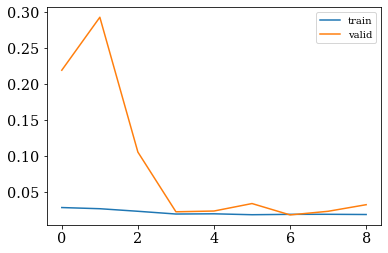

In [14]:
plt.plot(model_mses_train[1], label = "train")
plt.plot(model_mses_valid[1], label = "valid")
plt.legend();

In [15]:
np.argmin(model_mses_valid[1]) + 1

7

In [16]:
gen_model = model_list[1]

In [17]:
model = gen_model(np.argmin(model_mses_valid[1]) + 1)

X_tr = np.vstack((donor_train.iloc[:,1:].values, 
                  donor_valid.iloc[:,1:].values))

y_tr = np.vstack((treatment_train.values,
                 treatment_valid.values))

resids_train, resids_test = eval_model(model, 
                                       X_tr = log_transform(X_tr),
                                       y_tr = log_transform(y_tr),
                                       X_ts = log_transform(donor_test.iloc[:,1:].values),
                                       y_ts = log_transform(treatment_test)
                                      )

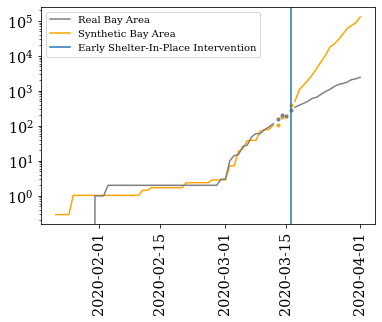

In [18]:
plt.semilogy(treatment_train.reset_index()["date"], 
             10**model.predict(log_transform(donor_train.iloc[:,1:])) - 1, 
             color = "orange")
plt.semilogy(treatment_train.reset_index()["date"], 
             10**log_transform(treatment_train) - 1, 
             color = "gray")

plt.semilogy(treatment_valid.reset_index()["date"], 
             10**model.predict(log_transform(donor_valid.iloc[:,1:])) - 1, '.',
             color = "orange")
plt.semilogy(treatment_valid.reset_index()["date"], 
             10**log_transform(treatment_valid) - 1, '.',
             color = "gray")

plt.semilogy(treatment_test.reset_index()["date"], 
             10**log_transform(treatment_test) - 1, 
             color = "gray", label = "Real Bay Area")
plt.semilogy(treatment_test.reset_index()["date"], 
             10**model.predict(log_transform(donor_test.iloc[:,1:])) - 1, 
             label = "Synthetic Bay Area", color = "orange")
plt.axvline(decision_date, label = "Early Shelter-In-Place Intervention")
plt.xticks(rotation = 90)
plt.legend();

plt.savefig("../results/synth.pdf", format = "pdf", bbox_inches = "tight")


In [19]:
time_labels = pd.concat([treatment_train.reset_index()["date"], 
                         treatment_valid.reset_index()["date"],
                         treatment_test.reset_index()["date"]])



treatment_resids = np.vstack((resids_train, resids_test))

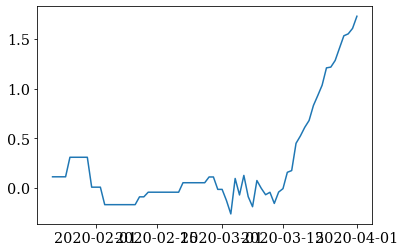

In [20]:
plt.plot(time_labels, treatment_resids)

In [21]:
def return_placebo_resids(placebo: str, donors: list, donor_tr: pd.DataFrame, 
                          treatment_tr: pd.DataFrame, donor_valid: pd.DataFrame,
                          treatment_valid: pd.DataFrame, donor_ts: pd.DataFrame, 
                          treatment_ts: pd.DataFrame) -> np.array:
    
    placebo_donors = set(donors) - set([placebo])
    
    X_placebo_tr = np.hstack((donor_tr[placebo_donors].values, treatment_tr.values))
    y_placebo_tr = donor_tr[[placebo]]
    X_placebo_valid = np.hstack((donor_valid[placebo_donors].values, treatment_valid.values))
    y_placebo_valid = donor_valid[[placebo]]    
    X_placebo_ts = np.hstack((donor_ts[placebo_donors].values,treatment_ts.values))
    y_placebo_ts = donor_ts[[placebo]]  
    
    log_transform = lambda x: np.log10(1+x)
    
    mses_train, mses_valid = grid_search(gen_model,
                                         num_components=len(placebo_donors),
                                         X_tr = log_transform(X_placebo_tr), 
                                         y_tr = log_transform(y_placebo_tr),
                                         X_valid = log_transform(X_placebo_valid),
                                         y_valid = log_transform(y_placebo_valid))
    
    
    model = gen_model(np.argmin(mses_valid)+1)

    X_tr = np.vstack((X_placebo_tr, 
                      X_placebo_valid))

    y_tr = np.vstack((y_placebo_tr,
                      y_placebo_valid))

    resids_train, resids_test = eval_model(model, 
                                           X_tr = log_transform(X_tr),
                                           y_tr = log_transform(y_tr),
                                           X_ts = log_transform(X_placebo_ts),
                                           y_ts = log_transform(y_placebo_ts)
                                          )    

    return np.vstack((resids_train, resids_test))

Los Angeles
Orange
Placer
Riverside
Sacramento
San Diego
San Joaquin
Santa Cruz
Solano
Sonoma


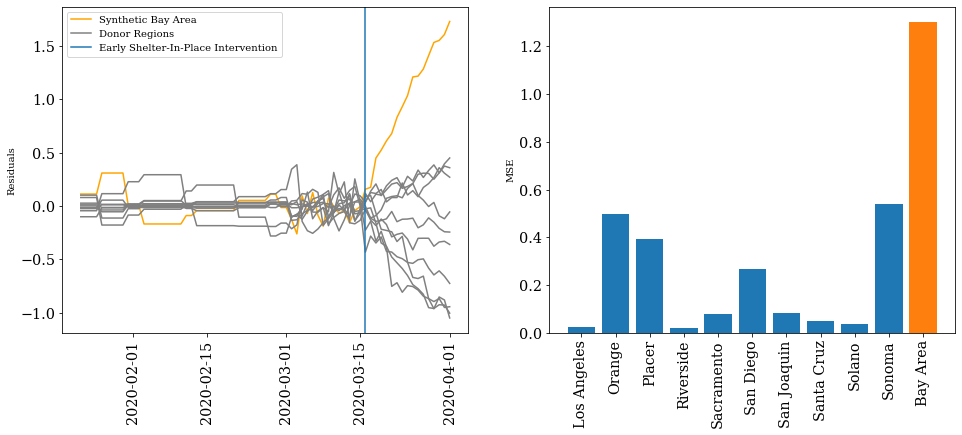

In [22]:
mses = []
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(time_labels, treatment_resids, label = "Synthetic Bay Area", color = "orange")
for i, placebo in enumerate(sorted(donor_counties)):
    print(placebo)
    placebo_resids = return_placebo_resids(placebo, donor_counties, 
                                           donor_train, treatment_train,
                                           donor_valid, treatment_valid,
                                           donor_test, treatment_test)
    if i == 0:
        plt.plot(time_labels, placebo_resids, color = "gray", label = "Donor Regions")
    else:
        plt.plot(time_labels, placebo_resids, color = "gray")
    mses.append(np.mean(placebo_resids[-len(donor_test):]**2))
plt.axvline(decision_date, label = "Early Shelter-In-Place Intervention")    
plt.legend()
plt.xticks(rotation = 90)
plt.ylabel("Residuals")

plt.subplot(1,2,2)
plt.bar(x = range(len(mses)), height =  mses);
plt.bar(x = len(mses), height = np.mean(treatment_resids[-len(donor_test):]**2))
plt.ylabel("MSE");
plt.xticks(range(11), sorted(donor_counties) + ["Bay Area"], rotation = 90);

plt.savefig("../results/resids.pdf", format = "pdf", bbox_inches = "tight")